In [1]:
# @title Install necessary libraries
import os
import multiprocessing
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    max(multiprocessing.cpu_count(), 1)
)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

try:
    import rexv2
    print("Rex already installed")
except ImportError as e:
    print("Please install rex via `pip install rex-lib[paper]`. Tested with rex-lib==0.0.3")
    raise e
    !pip install rex-lib[paper]

Rex already installed


In [2]:
# @title Import libraries & check GPU availability
from IPython.display import HTML
import functools
import jax
import itertools
import tqdm
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
from distrax import Deterministic, Normal
from rexv2.utils import timer
import rexv2.base as base
from rexv2.constants import RealTimeFactor, Clock 
from rexv2.base import StaticDist, TrainableDist

# Check if we have a GPU
try:
    gpu = jax.devices("gpu")
    gpu = gpu[0] if len(gpu) > 0 else None
    print("GPU found!")
except RuntimeError:
    print("Warning: No GPU found, falling back to CPU. Speedups will be less pronounced.")
    print("Hint: if you are using Google Colab, try to change the runtime to GPU: "
          "Runtime -> Change runtime type -> Hardware accelerator -> GPU.")
    gpu = None

# Check the number of available CPU cores
print(f"CPU cores available: {len(jax.devices('cpu'))}")
cpus = itertools.cycle(jax.devices("cpu"))

GPU found!
CPU cores available: 16


In [3]:
# @title Define pendulum system as interconnection of nodes
# @markdown We will first use the nodes defined in the pendulum example to define the simulated system
# @markdown We do not have a real-world system, so we will act as if the pendulum simulated with brax is the real-world system
# @markdown We will collect some data from the brax system and use it to identify the delays and parameters of a simple ODE model
# @markdown In another notebook example, we will show how to define nodes. 
# Import the nodes from the pendulum example (see other notebook examples on how to define nodes)
from rexv2.pendulum.nodes import Sensor, Agent, Actuator, BraxWorld

# `Color` and `order` arguments are merely for visualization purposes.
# Delay distributions are used to simulate the delays as if the nodes were real-world systems.
# For real-world systems, it is normally not necessary to specify the delay distributions.
sensor = Sensor(name="sensor", rate=20, color="pink", order=1,  # Sensor that reads the angle from the pendulum
                delay_dist=StaticDist.create(Normal(loc=0.01, scale=0.003)))  # Computation delay of the sensor
agent = Agent(name="agent", rate=20, color="teal", order=3, # Agent that generates random actions
              delay_dist=StaticDist.create(Normal(loc=0.01, scale=0.003)))  # Computation delay of the agent
actuator = Actuator(name="actuator", rate=20, color="orange", order=2,  # Actuator that applies the action to the pendulum
                    delay_dist=StaticDist.create(Normal(loc=0.01, scale=0.003)))  # Computation delay of the actuator
world = BraxWorld(name="world", rate=50, color="grape", order=0,  # Brax world that simulates the pendulum
                  delay_dist=StaticDist.create(Deterministic(loc=0.999/50)))  # Computation delay of the world
                  # 0.999 to ensure it's slightly less than the world's step size (numerical stability)
nodes = dict(world=world, sensor=sensor, agent=agent, actuator=actuator)

# Connect nodes
# The window determine the buffer size, i.e., the number of previous messages that are stored and can be accessed
# in the .step() method of the node. The window should be at least 1, as the most recent message is always stored.
agent.connect(sensor, window=3, name="sensor",  # Use the last three sensor messages as input (async communication)
              delay_dist=StaticDist.create(Normal(loc=0.005, scale=0.002)))  # Communication delay of the sensor
actuator.connect(agent, window=1, name="agent", blocking=True, # Agent receives the most recent action (sync communication)
                 delay_dist=StaticDist.create(Normal(loc=0.005, scale=0.002)))  # Communication delay of the agent

# Connections below would not be necessary in a real-world system, 
# but are used to communicate the action to brax, and convert brax's state to a sensor message
# Delay distributions are used to simulate the delays in the real-world system
world.connect(actuator, window=1, name="actuator", skip=True,  # Sends the action to the brax world (skip=True to resolve circular dependency)
              delay_dist=StaticDist.create(Normal(loc=0.05, scale=0.02)))  # Actuator delay between applying the action, and the action being effective in the world
sensor.connect(world, window=1, name="world",  # Communicate brax's state to the sensor node
               delay_dist=StaticDist.create(Normal(loc=0.05, scale=0.02)))  # Sensor delay between reading the state, and the world's state corresponding to the sensor reading.

2024-09-24 14:53:26.086141: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
# @title Apply some open-loop control to the pendulum system to generate data 

# Build the graph
# Note that one of the nodes is designated as the supervisor (agent).
# To make a comparison with the standard Gym-like approach, the supervisor node is the agent, and the other nodes are the environment.
# This means that the graph will be executed in a step-by-step manner, where the agent's rate determines the rate of the environment.
from rexv2.asynchronous import AsyncGraph
graph = AsyncGraph(nodes=nodes, supervisor=nodes["agent"],
                   # Settings for simulating at fast as possible speed according to specified delays
                   clock=Clock.SIMULATED, real_time_factor=RealTimeFactor.FAST_AS_POSSIBLE,
                   # Settings for simulating at real-time speed according to specified delays
                   # clock=Clock.SIMULATED, real_time_factor=RealTimeFactor.REAL_TIME,
                   # Settings for real-world deployment
                   # clock=Clock.WALL_CLOCK, real_time_factor=RealTimeFactor.REAL_TIME, 
                   )

# Get initial graph state (aggregate of all node states)
rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)
# 'order' defines the order in which the nodes must be initialized (some node initialization procedures may depend on the result of others)
gs_init = graph.init(rng_init, order=("agent",))

# Ahead-of-time compilation of the step method of each node 
# Place all nodes on the CPU, except the agent, which is placed on the GPU (if available)
devices_step = {k: next(cpus) if k != "agent" or gpu is None else gpu for k in nodes}
graph.warmup(gs_init, devices_step, jit_step=True, profile=True)  # Profile=True for profiling the step function

# Specify what we want to record (params, state, output) for each node, 
[n.set_record_settings(params=True, inputs=False, state=True, output=True) for n in nodes.values()]

# Prepare open-loop action sequence
rng, rng_actions = jax.random.split(rng)
dt_action = 2.0
num_actions = 6
actions = jax.random.uniform(rng_actions, shape=(num_actions, 1), minval=-2.0, maxval=2.0)
actions = jnp.repeat(actions, int(jnp.ceil(dt_action * nodes["agent"].rate)), axis=0)  # Repeat actions for the duration of the agent's rate
num_steps = actions.shape[0]

# Run for one episode
gs, ss = graph.reset(gs_init) # Reset the graph to the initial state (returns the gs and the step state of the agent)
for i in range(num_steps):
    action = actions[i]  # Get the action for the current time step
    output = ss.params.to_output(action)  # Convert the action to an output message
    gs, ss = graph.step(gs, ss, output)  # Step the graph with the agent's output
graph.stop()  # Stops all nodes that were running asynchronously in the background

# Visualize the first second of two generated computation graphs
# Notice the slight differences in the graphs due to random delays and phase shifts
# fig, axs = plt.subplots(2, 1, figsize=(12, 10))
# Gs = [compiler.utils.to_networkx_graph(graphs_raw[i], nodes=nodes) for i in range(2)]
# for i, G in enumerate(Gs):
#     supergraph.plot_graph(G, max_x=0.3, ax=axs[i])
#     axs[i].set_title(f"Episode {i}")
#     axs[i].set_xlabel("Time [s]")

[20607][MainThread               ][tracer              ][world.step | pre-compile ] Elapsed: 1.2802 sec
[20607][MainThread               ][tracer              ][world.step | time-profile] Elapsed: 0.0014 sec (x10 repeats = 0.0141 sec)
[20607][MainThread               ][tracer              ][sensor.step | pre-compile ] Elapsed: 0.0207 sec
[20607][MainThread               ][tracer              ][sensor.step | time-profile] Elapsed: 0.0002 sec (x10 repeats = 0.0019 sec)
[20607][MainThread               ][tracer              ][agent.step | pre-compile ] Elapsed: 0.1253 sec
[20607][MainThread               ][tracer              ][agent.step | time-profile] Elapsed: 0.0003 sec (x10 repeats = 0.0026 sec)
[20607][MainThread               ][tracer              ][actuator.step | pre-compile ] Elapsed: 0.0196 sec
[20607][MainThread               ][tracer              ][actuator.step | time-profile] Elapsed: 0.0002 sec (x10 repeats = 0.0016 sec)


In [5]:
record = graph.get_record()
df = record.to_graph()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (242,) + inhomogeneous part.

Growing supergraph: 100%|██████████| 1010/1010 [00:02<00:00, 341.19it/s, 10/10 graphs, 11040/11040 matched (99.37% efficiency, 11 nodes (pre-filtered: 11 nodes))]


Text(0.5, 0, 'Topological generation')

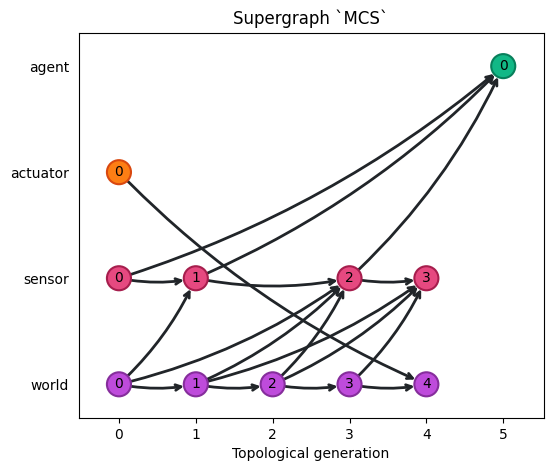

In [5]:
## @title Compile graphs (partition and find supergraph)
# @markdown  The agent is the supervisor, hence all other nodes will constitute the environment from the agent's perspective
# @markdown  Incoming connections (sensor) to the agent are observations, while outgoing connections (actuator) are actions
supergraph_method = "MCS"  # Other options "MCS", "topological", or "generational"
graph = compiler.graph.Graph(nodes, agent, graphs_raw, supergraph_mode="MCS", progress_bar=True)
# graph.init = jax.jit(graph.init, static_argnames=("order",))  # Compile the init function
graph.reset = jax.jit(graph.reset)  # Compile the reset function
graph.step = jax.jit(graph.step)  # Compile the step function
graph.run = jax.jit(graph.run)  # Compile the run function

# Next, we visualize the identified supergraph that will be run every step of the simulation.
# @markdown Notice how the agent is the supervisor, meaning there can only be one agent vertex.
# @markdown Moreover, it must be a root of the supergraph.
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
supergraph.plot_graph(graph.S, ax=ax)
ax.set_title(f"Supergraph `{supergraph_method}`")
ax.set_xlabel("Topological generation")

Text(0.5, 0, 'Time [s]')

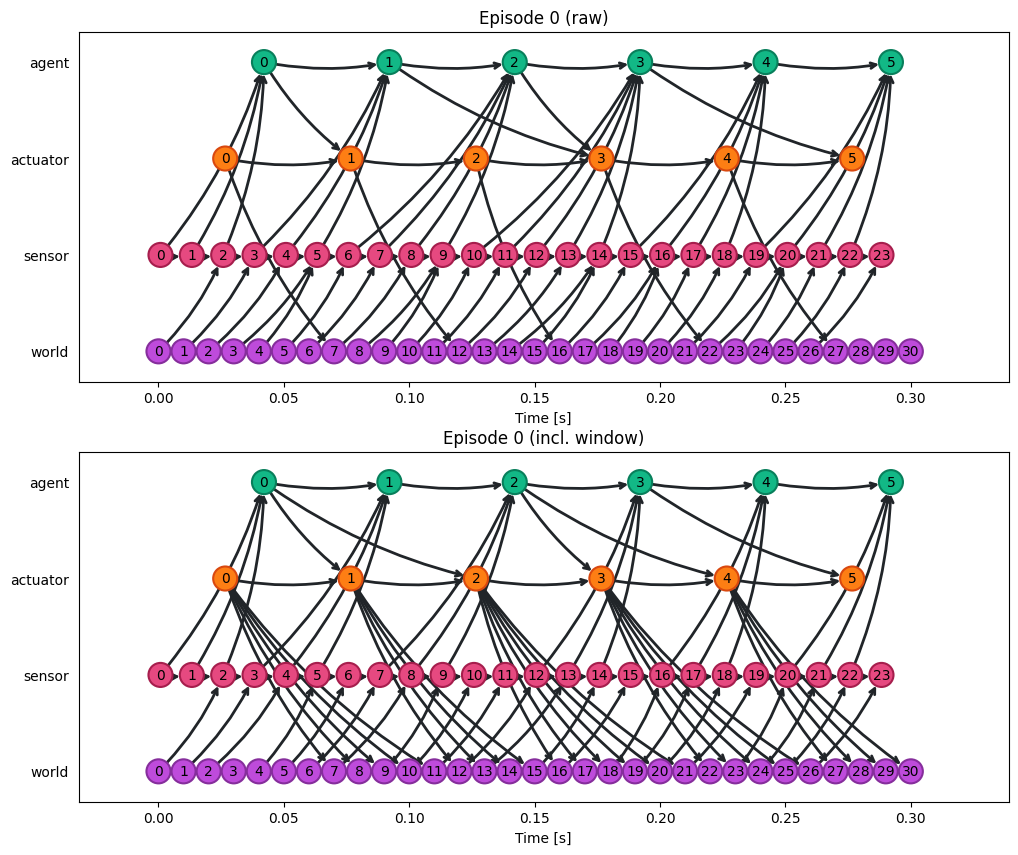

In [6]:
# @title Emphasize difference between
# @markdown
# @markdown The provided computation graphs are "raw" in that they only represent the data flow of a system,
# @markdown without considering the fact that some messages may be used in multiple step calls, when no new data is available,
# @markdown or that some messages may be discarded if they fall out of the buffer size.
# @markdown In other words, before feeding the computation graphs to the supergraph finding algorithm, we processed
# @markdown the graphs to take into account the buffer sizes (i.e. window sizes) of the connections.
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# The raw computation graph, as provided by the compiler (same as above)
supergraph.plot_graph(Gs[0], max_x=0.3, ax=axs[0])
axs[0].set_title(f"Episode 0 (raw)")
axs[0].set_xlabel("Time [s]")

# The one that is used for actual computation, which takes into account the window sizes of the connections
supergraph.plot_graph(graph.Gs[0], max_x=0.3, ax=axs[1])
axs[1].set_title(f"Episode 0 (incl. window)")
axs[1].set_xlabel("Time [s]")

# @markdown Notice how in the second graph, edges from the actuator to the world are repeated,
# @markdown to reflect that the actuator message is used in multiple step calls.
# @markdown Similarly, the agent has three incomding edges from the sensor, reflecting the window size of the sensor connection.

In [7]:
# @title Simulation execution: Gym-like API with .reset() & .step() methods
# @markdown Next, we will initialize the graph state with .init() and perform step-by-step simulation.

# The graph state contains the state of each node, but also what episode graph is currently being executed, and
# the current time within the episode, that is, what partitions have already been executed.
# As we will see later in the node definition, the state of a node is divided into params, states, and input buffers.
rng = jax.random.PRNGKey(1)

# Initialize the graph state
# The order can be important, as it defines the order in which the nodes must be initialized.
# That is, some node initialization procedures may depend on the result of others.
gs = graph.init(rng, randomize_eps=True, order=("world",))

# Gym-API like interface, where the user calls reset() and step() methods
gs, ss = graph.reset(gs)  # Reset the graph state, returns the initial observation (in ss)
rollout = [gs]
pbar = tqdm.tqdm(range(graph.max_steps))
for _ in pbar:  # Simulate for a number of steps
    # Access the last sensor message of the input buffer
    # -1 is the most recent message, -2 the second most recent, etc. up until the window size
    sensor_msg = ss.inputs["sensor"][-1].data # .data grabs the pytree message object

    # Devise an action, prepare the output message, and update the step_state.
    rng_next, rng_action = jax.random.split(ss.rng, num=2)
    action = jax.random.uniform(rng_action, shape=(1,), minval=-2.0, maxval=2.0)
    output = pendulum.nodes.ActuatorOutput(action=action) # Define output
    next_ss = ss.replace(rng=rng_next)  # Update the step state

    # Print the current time, sensor reading, and action
    pbar.set_postfix_str(f"step: {ss.seq}, ts_start: {ss.ts:.2f}, th: {sensor_msg.th:.2f}, thdot: {sensor_msg.thdot:.2f}, Action: {action[0]:.2f}")

    # Step the graph (i.e., executes the next time step by sending the output message to the actuator node)
    gs, ss = graph.step(gs, step_state=next_ss, output=output)  # Step the graph
    rollout.append(gs)
pbar.close()

100%|██████████| 100/100 [00:03<00:00, 25.22it/s, step: 99, ts_start: 5.00, th: 3.86, thdot: -4.27, Action: -1.49]


In [8]:
# @title Visualize rollout
# @markdown Although the dynamics were simulated using an ode, we use the brax visualizer
# @markdown  to visualize the rollout in an interactive manner.
# Html visualization may not work properly, if it's already rendering somewhere else.
# In such cases, comment-out all but one HTML(pendulum.render(rollout))
HTML(pendulum.render(rollout))

In [9]:
# @title Simulation execution: Alternative API with .run() method.

# The previous example follows the Gym-API like interface, but completely ignores
# the step() method of the supervisor node (agent).
# In some cases, it may be convenient to run the graph including the step() method
# of the supervisor node (agent).
# For this, we expose an alternative interface using the .run() method.

# Again, we initialize the graph state
gs = graph.init(rng, randomize_eps=True, order=("world",))

# However, now we will repeatedly call the run() method, which will call the step() method of the agent node.
# In our case, the agent node is a random agent, so it will also generate random actions.
rollout = [gs]
pbar = tqdm.tqdm(range(graph.max_steps))
for _ in pbar:
    gs = graph.run(gs)  # Run the graph (incl. the agent's step() method)
    rollout.append(gs)
    # We can access the agent's state directly (this is the state *after* the step() method was called)
    ss = gs.nodes["agent"]
    # Print the current time, sensor reading, and action
    pbar.set_postfix_str(f"step: {ss.seq}, ts_start: {ss.ts:.2f}")
pbar.close()

# Html visualization may not work properly, if it's already rendering somewhere else.
# In such cases, comment-out all but one HTML(pendulum.render(rollout))
# HTML(pendulum.render(rollout))

100%|██████████| 100/100 [00:03<00:00, 28.32it/s, step: 100, ts_start: 5.00]


Jit-compilation[graph.init] | Elapsed: 1.6162 sec
Jit-compilation[graph.rollout] | Elapsed: 8.0642 sec
Vectorized rollout of 500 rollouts | Elapsed: 0.0932 sec (x10 repeats = 0.9316 sec)

Simulation speed: 536711 steps/second (depends on hardware)


Text(0, 0.5, 'Action')

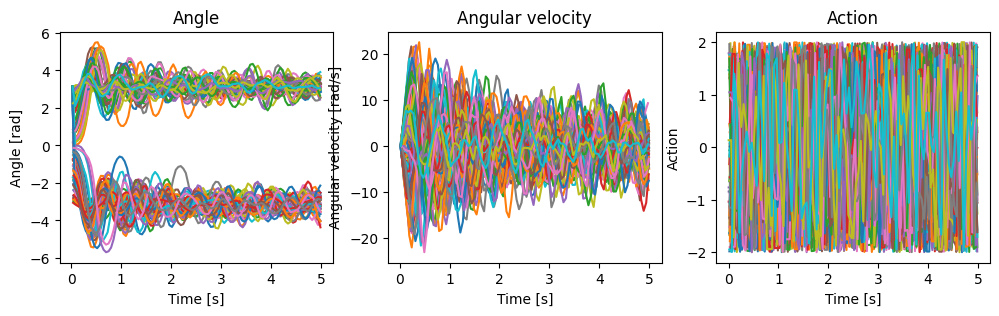

In [10]:
# @title Vectorized rollouts
# We may also perform many rollouts in parallel by using jax.vmap
num_rollouts = 500
rngs = jax.random.split(jax.random.PRNGKey(2), num=num_rollouts)

# Vectorized graph initialization
graph_init = functools.partial(graph.init, randomize_eps=True, order=("world",))
graph_init_jv = jax.jit(jax.vmap(graph_init, in_axes=0))

# Vectorized graph rollout with .rollout() convenience function
graph_rollout_jv = jax.jit(jax.vmap(graph.rollout, in_axes=0))

# Check if we have a GPU
try:
    gpu = jax.devices("gpu")
except RuntimeError:
    print("Warning: No GPU found, falling back to CPU. Speedups will be less pronounced.")
    print("Hint: if you are using Google Colab, try to change the runtime to GPU: "
          "Runtime -> Change runtime type -> Hardware accelerator -> GPU.")

# During the first call, the two functions are compiled
with timer("Jit-compilation[graph.init]"):
    gs = graph_init_jv(rngs)
with timer("Jit-compilation[graph.rollout]"):
    rollout = graph_rollout_jv(gs, eps=gs.eps)

# Subsequent calls are much faster
# @markdown  Note that the speedups require a GPU. On a CPU, the speedups for the vectorized rollout are less pronounced.
t = timer(f"Vectorized rollout of {num_rollouts} rollouts", repeat=10)
with t:
    for _ in range(10):
        gs = graph_init_jv(rngs)
        rollout = graph_rollout_jv(gs, eps=gs.eps)
fps = (graph.max_steps * num_rollouts*t.repeat) / t.duration
print(f"\nSimulation speed: {fps:.0f} steps/second (depends on hardware)\n")

# Visualize rollouts
num_viz = min(100, num_rollouts)
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(rollout.nodes["agent"].ts[:num_viz, :].T, rollout.nodes["agent"].inputs["sensor"].data.th[:num_viz, :, -1].T)
axs[0].set_title("Angle")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Angle [rad]")
axs[1].plot(rollout.nodes["agent"].ts[:num_viz, :].T, rollout.nodes["agent"].inputs["sensor"].data.thdot[:num_viz, :, -1].T)
axs[1].set_title("Angular velocity")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Angular velocity [rad/s]")
axs[2].plot(rollout.nodes["actuator"].ts[:num_viz, :].T, rollout.nodes["actuator"].inputs["agent"].data.action[:num_viz, :, -1, 0].T)
axs[2].set_title("Action")
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel("Action")

In [11]:
# @title Defining a custom node (Brax)
# @markdown Next, we will explain how to define custom nodes.
# @markdown Up until now, we used a world node that uses a set of ODE's to simulate the pendulum.
# @markdown We will define a node that uses brax to simulate the pendulum swing-up task.
from typing import Tuple, Union
from supergraph.compiler.base import GraphState, StepState
from math import ceil
from brax.generalized import pipeline as gen_pipeline
from brax.io import mjcf
from flax import struct

# First, we define the parameters, state, and output of the node
# These are pytree structures that can be arbitrarily nested
# More info on pytrees can be found here: https://jax.readthedocs.io/en/latest/pytrees.html
# More info on flax.struct can be found here: https://flax.readthedocs.io/en/latest/api_reference/flax.struct.html
@struct.dataclass
class BraxParams:
    """Brax's param definition"""
    friction_loss: Union[float, jax.typing.ArrayLike]  # We augment brax with static friction
    sys: gen_pipeline.System  # Brax system definition


@struct.dataclass
class BraxState:
    """Brax's state definition"""
    pipeline_state: gen_pipeline.State  # Brax state definition


@struct.dataclass
class WorldOutput:
    """World output definition"""
    th: Union[float, jax.typing.ArrayLike]  # The angle of the pendulum
    thdot: Union[float, jax.typing.ArrayLike] # The angular velocity of the pendulum


# Next, we define the node itself
class BraxWorld(compiler.node.BaseNode):
    def __init__(self, name: str, rate: float, color: str = None, order: int = None, dt_substeps: float = 1 / 100):
        """
        Initialize the brax world node.

        :param name: The name of the node (unique).
        :param rate: The rate of the node (Hz).
        :param color: The color of the node (for visualization).
        :param order: The order of the node (for visualization).
        :param dt_substeps: The time step of the substeps.
        """
        super().__init__(name, rate, color=color, order=order)
        self.sys = mjcf.loads(pendulum.nodes.DISK_PENDULUM_XML)  # Load the pendulum xml
        dt = 1 / self.rate
        self.substeps = ceil(dt / dt_substeps)  # We may need to run multiple substeps per step
        self.dt_substeps = dt / self.substeps   # The time step of the substeps

    def init_params(self, rng: jax.Array = None, graph_state: GraphState = None) -> BraxParams:
        """
        Initialize the default params of the brax node.

        The params of the node are usually considered to be static during an episode (e.g. dynamic params, network weights).

        At this point, the graph state may contain the params of other nodes required to get the default params.
        The order of node initialization can be specified in Graph.init(... order=[node1, node2, ...]).

        :param rng: Random number generator.
        :param graph_state: The graph state that may be used to get the default params.
        :return: The default params of the node.
        """
        # Realistic parameters for the disk pendulum
        damping = 0.00015877
        armature = 6.4940527e-06
        gear = 0.00428677
        mass_weight = 0.05076142
        radius_weight = 0.05121992
        offset = 0.04161447
        friction_loss = 0.00097525

        # Appropriately replace parameters for the disk pendulum
        itransform = self.sys.link.inertia.transform.replace(pos=jnp.array([[0., offset, 0.]]))
        i = self.sys.link.inertia.i.at[0, 0, 0].set(0.5 * mass_weight * radius_weight ** 2)  # inertia of cylinder in local frame.
        inertia = self.sys.link.inertia.replace(transform=itransform, mass=jnp.array([mass_weight]), i=i)
        link = self.sys.link.replace(inertia=inertia)
        actuator = self.sys.actuator.replace(gear=jnp.array([gear]))
        dof = self.sys.dof.replace(armature=jnp.array([armature]), damping=jnp.array([damping]))
        new_sys = self.sys.replace(link=link, actuator=actuator, dof=dof, dt=self.dt_substeps)
        return BraxParams(friction_loss=friction_loss, sys=new_sys)

    def init_state(self, rng: jax.Array = None, graph_state: GraphState = None) -> BraxState:
        """
        Initialize the default state of the brax node.

        The state of the node is usually considered to be dynamic during an episode (e.g. position, velocity).

        At this point, the params of all nodes are already initialized and present in the graph state (if specified).
        Moreover, the state of other nodes required to get the default state may also be present in the graph state.
        The order of node initialization can be specified in Graph.init(... order=[node1, node2, ...]).

        :param rng: Random number generator.
        :param graph_state: The graph state that may be used to get the default state.
        :return: The default state of the node.
        """
        if rng is None:
            rng = jax.random.PRNGKey(0)

        # Sample initial state
        init_th = jax.random.uniform(rng, shape=(), minval=-onp.pi, maxval=onp.pi)
        init_thdot = jax.random.uniform(rng, shape=(), minval=-2., maxval=2.)

        # Set the initial state of the disk pendulum
        step_state = self.get_step_state(graph_state)
        params = step_state.params if step_state else self.init_params(rng, graph_state)
        qpos = params.sys.init_q.at[0].set(init_th)
        qvel = jnp.array([init_thdot])
        pipeline_state = gen_pipeline.init(params.sys, qpos, qvel)
        return BraxState(pipeline_state=pipeline_state)

    def init_output(self, rng: jax.Array = None, graph_state: GraphState = None) -> WorldOutput:
        """
        Initialize the default output of the brax node.

        It is common for nodes not to share their full state with other nodes.
        Hence, the output of the node is usually a subset of the state that is shared with other nodes.

        These outputs are used to initialize the inputs of other nodes. In the case where a node may not have received
        any messages from a connected node, the default outputs are used to fill the input buffers.

        Usually, the params and state of every node are already initialized and present in the graph state.
        However, it's usually preferred to define the output without relying on the graph state.

        :param rng: Random number generator.
        :param graph_state: The graph state that may be used to get the default output.
        :return: The default output of the node.
        """
        # Grab output from state
        ss_world = self.get_step_state(graph_state)
        state = ss_world.state if ss_world else self.init_state(rng, graph_state)
        return WorldOutput(th=state.pipeline_state.q[0], thdot=state.pipeline_state.qd[0])

    def step(self, step_state: StepState) -> Tuple[StepState, WorldOutput]:
        """Step the node for the seq'th time step at time ts.

        This step function is the main function that is called to update the state of the node and produce an output, that
        is sent to the connected nodes. The step function is called at the rate of the node.

        The step_state is a dataclass that contains all data to run the seq'th step at time ts, during episode `eps`
        Specifically, it contains the params, state, inputs[connected_node_name], eps, seq, and ts.

        The inputs are interfaced as inputs[some_name][window_index].data. A window_index of -1 leads to the most recent message.
        Auxiliary information such as the sequence number, and the time sent and received are also stored in the InputState.
        This information can be accessed as inputs[some_name][window_index].seq, inputs[some_name][window_index].ts_sent, and
        inputs[some_name][window_index].ts_recv, respectively, where ts_sent and ts_recv are the time the message was sent and
        received, respectively.

        Note that the user is expected to update the state (and rng if used), but not the seq and ts, as they are
        automatically updated.

        :param step_state: The step state of the node.
        :return: The updated step state and the output of the node.
        """

        # Unpack StepState
        _, state, params, inputs = step_state.rng, step_state.state, step_state.params, step_state.inputs

        # Get action
        action = inputs["actuator"].data.action[-1]

        # Brax does not have static friction implemented
        thdot = state.pipeline_state.qd[0]
        activation = jnp.sign(thdot)
        friction = params.friction_loss * activation / params.sys.actuator.gear[0]
        action_friction = action - friction

        # Run the pipeline for the number of substeps
        def f(state, _):
            return (
                gen_pipeline.step(self.sys, state, action_friction),
                None,
            )

        new_pipeline_state = jax.lax.scan(f, state.pipeline_state, (), self.substeps)[0]

        # Update state
        new_state = state.replace(pipeline_state=new_pipeline_state)
        new_step_state = step_state.replace(state=new_state)

        # Prepare output
        output = WorldOutput(th=new_pipeline_state.q[0], thdot=new_pipeline_state.qd[0])

        return new_step_state, output

In [12]:
# @title Defining pendulum system with Brax
# @markdown Lets create a new graph with the brax world node
world = BraxWorld(name="world", rate=100, color="grape", order=0)
sensor = pendulum.nodes.Sensor(name="sensor", rate=80, color="pink", order=1)
agent = pendulum.nodes.RandomAgent(name="agent", rate=20, color="teal", order=3)  # Random agent that generates random actions
actuator = pendulum.nodes.Actuator(name="actuator", rate=20, color="orange", order=2)
nodes = dict(world=world, sensor=sensor, agent=agent, actuator=actuator)

# Connect nodes
# The window determine the buffer size, i.e., the number of previous messages that are stored and can be accessed
# in the .step() method of the node. The window should be at least 1, as the most recent message is always stored.
world.connect(actuator, window=1, name="actuator", skip=True) # Skip resolves potential circular dependencies in the artifically generated computation graphs
sensor.connect(world, window=1, name="world")
actuator.connect(agent, window=1, name="agent")
agent.connect(sensor, window=3, name="sensor")

# Compile graphs (partition and find supergraph)
# The agent is the supervisor, hence all other nodes will constitute the environment from the agent's perspective
# Incoming connections (sensor) to the agent are observations, while outgoing connections (actuator) are actions
supergraph_method = "MCS"  # Other options "MCS", "topological", or "generational"
graph = compiler.graph.Graph(nodes, agent, graphs_raw, supergraph_mode="MCS", progress_bar=True)
# graph.init = jax.jit(graph.init, static_argnames=("order",))  # Compile the init function
graph.reset = jax.jit(graph.reset)  # Compile the reset function
graph.step = jax.jit(graph.step)  # Compile the step function
graph.run = jax.jit(graph.run)  # Compile the run function

Growing supergraph: 100%|██████████| 1010/1010 [00:02<00:00, 464.38it/s, 10/10 graphs, 11040/11040 matched (99.37% efficiency, 11 nodes (pre-filtered: 11 nodes))]


In [13]:
# @title Rollout with Brax pendulum system
# Again, we initialize the graph state
gs = graph.init(rng, randomize_eps=True, order=("world",))

# Followed by repeatedly calling
rollout = [gs]
pbar = tqdm.tqdm(range(graph.max_steps))
for _ in pbar:
    gs = graph.run(gs)  # Run the graph (incl. the agent's step() method)
    rollout.append(gs)
    # We can access the agent's state directly (this is the state *after* the step() method was called)
    ss = gs.nodes["agent"]
    # Print the current time, sensor reading, and action
    pbar.set_postfix_str(f"step: {ss.seq}, ts_start: {ss.ts:.2f}")
pbar.close()

100%|██████████| 100/100 [00:15<00:00,  6.48it/s, step: 100, ts_start: 5.00]


In [14]:
# @title Visualize rollout
# Use brax to visualize the rollout
# Html visualization may not work properly, if it's already rendering somewhere else.
# In such cases, comment-out all but one HTML(pendulum.render(rollout))
HTML(pendulum.render(rollout))